In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from utils import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

In [4]:
data_dir = "../Data_Cropped_and_Resized"

### Feature Extraction

In [5]:
train_path = f"{data_dir}/train"

train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units)
_, train_threshold_edges, _ = extract_features(train_path, threshold_image)

In [7]:
valid_path = f"{data_dir}/valid"

valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units)
_, valid_threshold_edges, _ = extract_features(train_path, threshold_image)

### Dimensionality Reduction (PCA)

In [11]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

In [16]:
training_features = [[img.flatten() for img in train_sobel_edges],
            [img.flatten() for img in train_hounsfield_edges],
            [img.flatten() for img in train_threshold_edges]]

IndexError: list index out of range

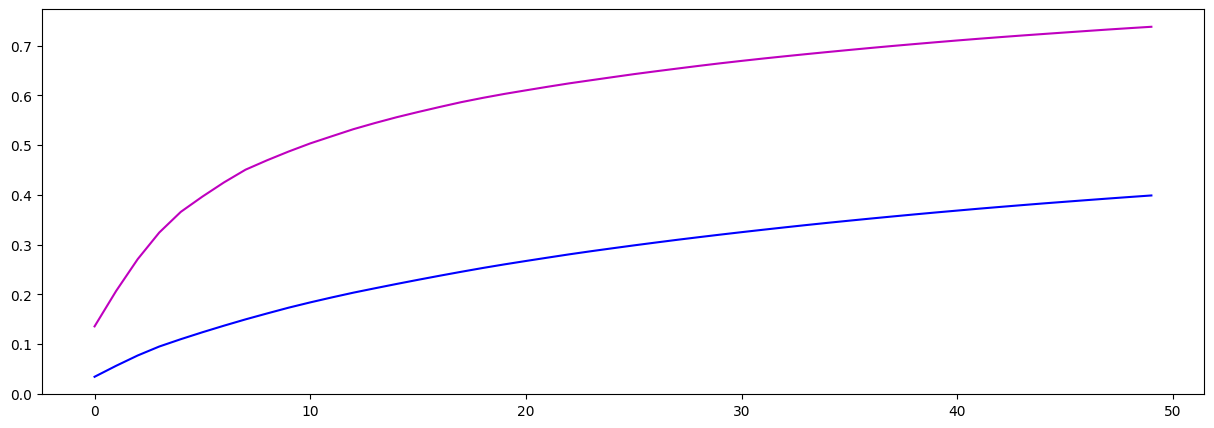

In [17]:
labels = ['sobel edges', 'houndsfield edges', 'threshold edges']

x = plot_PCA(training_features, labels, n_components=50)

In [12]:
# dimensionality reduction

input_features = np.array([[img.flatten() for img in train_sobel_edges],
                                   [img.flatten() for img in train_hounsfield_edges]])

X_sobel_pca, X_hounsfield_pca = get_PCA(input_features, n_components=2)[-1]

X_sobel_tsne, X_hounsfield_tsne = get_tsne(input_features, n_components=2)

In [29]:
def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in range(len(np.unique(y))):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

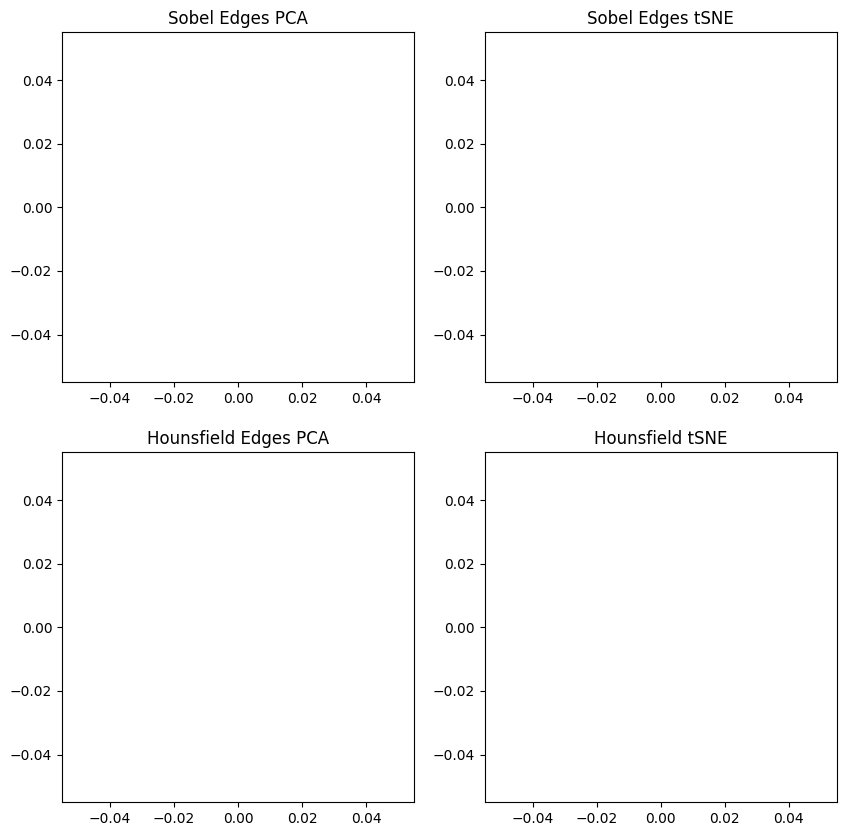

In [30]:
# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# y is the class labels (person ID)
plot_classes(X_sobel_pca, train_labels, ax[0,0], title='Sobel Edges PCA')
plot_classes(X_sobel_tsne, train_labels, ax[0,1], title='Sobel Edges tSNE')

plot_classes(X_hounsfield_pca, train_labels, ax[1,0], title='Hounsfield Edges PCA')
plot_classes(X_hounsfield_tsne, train_labels, ax[1,1], title='Hounsfield tSNE')

plt.show()

### SVM

##### Sobel Edges

In [17]:
clf = SVC(C=1e10, kernel="linear")
clf.fit(X_sobel_pca, train_labels)

SVC(C=10000000000.0, kernel='linear')

In [47]:
X_sobel_pca_df = pd.DataFrame({"x": X_sobel_pca[:,0],
                                "y": X_sobel_pca[:,1],
                                "label": train_labels
                                })

w = [8238.82209015 -598.62288284]
b = [1300.11150218  947.21520764  374.30508984   60.63156467  -68.846573
 -115.8290397 ]


<ipython-input-49-193d8ab2243b>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_sobel_pca_df[X_sobel_pca_df['label'] == l]['x'],


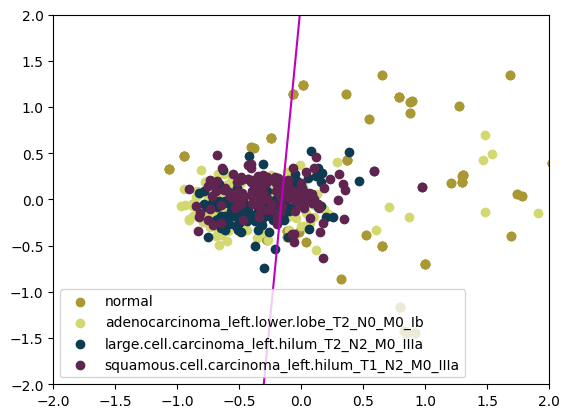

In [49]:
w = clf.coef_[0]
b = clf.intercept_

colors = np.random.rand(len(class_mappings.keys()), 3)

print(f"w = {w}")
print(f"b = {b}")

svmx = np.linspace(-2,2)
svmy = -w[0]/w[1]*svmx - b[0]/w[1]

fix = plt.figure()
ax = fig.add_subplot(111)
for l in class_mappings.keys():
  plt.scatter(X_sobel_pca_df[X_sobel_pca_df['label'] == l]['x'],
              X_sobel_pca_df[X_sobel_pca_df['label'] == l]['y'],
              c=colors[l], label=class_mappings[l])
plt.plot(svmx, svmy, "m")
plt.legend()
plt.axis([-2, 2, -2, 2])
plt.show()

##### Hounsfield Edges

In [27]:
clf2 = SVC(C=1e10, kernel="linear")
clf2.fit(X_hounsfield_pca, train_labels)

SVC(C=10000000000.0, kernel='linear')

In [35]:
X_hounsfield_pca_df = pd.DataFrame({"x": X_hounsfield_pca[:,0],
                                    "y": X_hounsfield_pca[:,1],
                                    "label": train_labels
                                    })

w = [5120.13582611 1189.65494537]
b = [-628.57829891 1308.03548014 -492.91678338 1426.89544402  380.01713041
 -455.22441017]


<ipython-input-46-67cb8f0d1fd1>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_hounsfield_pca_df[X_hounsfield_pca_df['label'] == l]['x'],


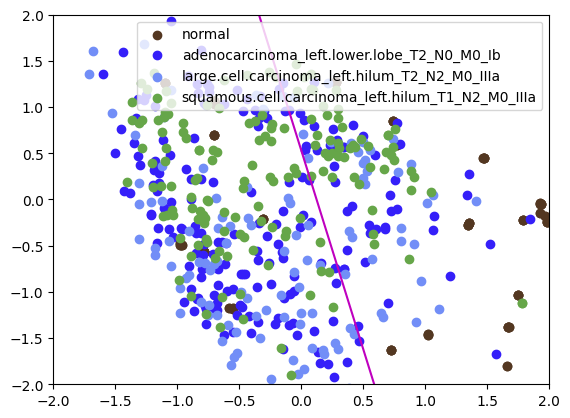

In [46]:
w = clf2.coef_[0]
b = clf2.intercept_

colors = np.random.rand(len(class_mappings.keys()), 3)

print(f"w = {w}")
print(f"b = {b}")

svmx = np.linspace(-2,2)
svmy = -w[0]/w[1]*svmx - b[0]/w[1]

fix = plt.figure()
ax = fig.add_subplot(111)
# plt.plot(X_hounsfield_pca[:,0],X_hounsfield_pca[:,1], "bo")
for l in class_mappings.keys():
  plt.scatter(X_hounsfield_pca_df[X_hounsfield_pca_df['label'] == l]['x'],
              X_hounsfield_pca_df[X_hounsfield_pca_df['label'] == l]['y'],
              c=colors[l], label=class_mappings[l])
plt.plot(svmx, svmy, "m")
plt.legend()
plt.axis([-2, 2, -2, 2])
plt.show()